# Using R-peak as main fitting parameter
### We will now be:
1. Finding R peak (highest)
2. Fitting R peak
3. Finding the minimum left of R (aka Q), and fitting
4. Finding the maximum left of Q (aka P), and fitting
5. Finding minimum right of R (aka S), and fitting
6. Finding maxmimum right of S (aka T), and fitting

## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import numpy as np
import os

from py_files.extract import extract_data, extract_metadata

from bycycle import features, cyclepoints, plts

from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import detrend

from neurodsp.filt import filter_signal
from neurodsp.plts import plot_power_spectra
from neurodsp.spectral import compute_spectrum
import neurokit2 as nk

import sys
sys.path.append("../")
from scripts.funcs import *

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (20, 10)

## Load Data and Isolate Signal

In [6]:
# Data paths
dir_path = '/Users/morganfitzgerald/Projects/ecg_param/data'
files_dat = [i for i in sorted(os.listdir(dir_path)) if i.endswith('dat')]
files_hea = [i for i in sorted(os.listdir(dir_path)) if i.endswith('hea')]
# files_hea = [i for i in files_hea if i != '0400.hea'] # missing one participant's data

In [7]:
# Assuming files_dat is a list of filenames
# Iterate over the list
for filename in files_dat:
    # Extract subject number
    sub_num = os.path.splitext(filename)[0]
    
    # Ensure the extracted part is numeric (remove leading zeros)
    sub_num = str(int(sub_num))
    
    # Define SUB_NUM variable
    SUB_NUM = sub_num
    
    # Print the result
    print(f"Subject Number for {filename}: {SUB_NUM}")

Subject Number for 0001.dat: 1


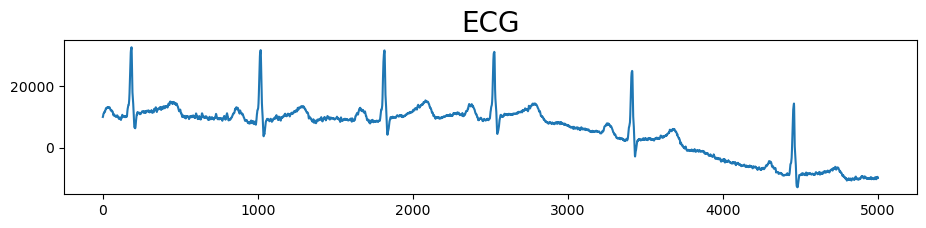

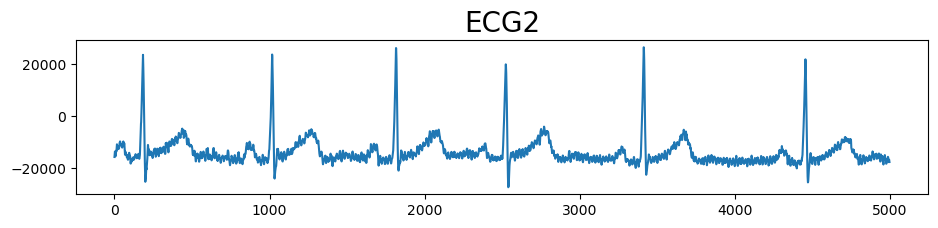

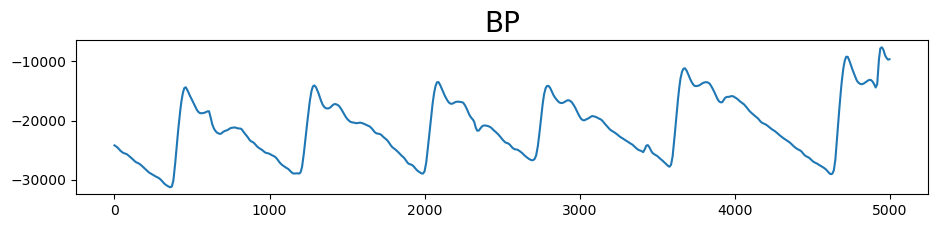

In [9]:
SUB_NUM = 0
# Extract single subject
sigs, metadata = extract_data(
    os.path.join(dir_path, files_dat[SUB_NUM]),
    os.path.join(dir_path, files_hea[SUB_NUM]),
    raw_dtype='int16'
)

CROP_MIN = 10000
CROP_MAX = 15000

# Most subjects have two or three 'channels': one or two ecg and one pulse
#ECG should be one lead, and ECG2 should be two leads. We want ECG2, but suspect that it might be mislabeled on some.
plt.figure(0, figsize=(11, 2))
plt.plot(sigs[0][CROP_MIN:CROP_MAX])
plt.title('ECG', size=20)
plt.figure(1, figsize=(11, 2))
plt.title('ECG2', size=20)
plt.plot(sigs[1][CROP_MIN:CROP_MAX])
if len(sigs) == 3:
    plt.figure(2, figsize=(11, 2))
    plt.title('BP', size=20)
    plt.plot(sigs[2][CROP_MIN:CROP_MAX])

In [10]:
# Pull out desired signal - 'sigs[0-2]' will be ECG, ECG2 and BP
ecg = sigs[1]

#FS = sampling rate; The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
FS = 1000

## Clean Signal (*Neurokit*)

Text(0.5, 1.0, 'Participant 0: ECG Raw')

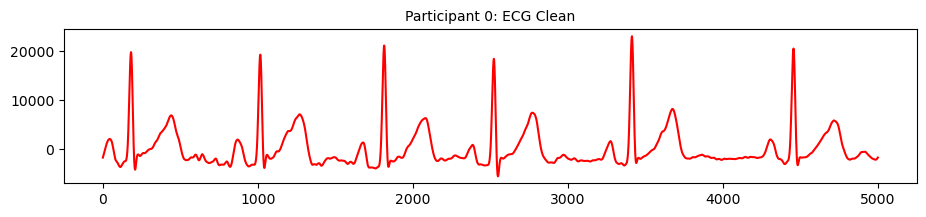

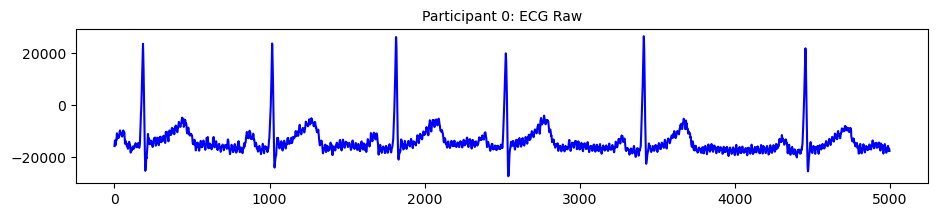

In [11]:
# NK applies a highpass Butterworth filter
#Remove slow drift and DC offset, ensuring that only the variations in the signal within a certain frequency range are retained (lowcut=0.5)
ecg_clean = nk.ecg_clean(ecg, sampling_rate=1000)

#ecg_clean is all the y values of our signal


plt.figure(0, figsize=(11, 2))
plt.plot(ecg_clean[CROP_MIN:CROP_MAX], color = 'r')
plt.title(f'Participant {SUB_NUM}: ECG Clean', size=10)


plt.figure(1, figsize=(11, 2))
plt.plot(sigs[1][CROP_MIN:CROP_MAX], color = 'b')
plt.title(f'Participant {SUB_NUM}: ECG Raw', size=10)


## Extract Control Points (*Neurokit*)

Here we use Neurokit's toolbox to: 
1. Extract the rpeaks using ecg_peaks 
2. Extract the remaining peaks using ecg_deliniate

In [185]:
# FIND R PEAKS

#_, is often done when you want to call a function that returns multiple values, but you're only interested in some of those values. 
#It helps to improve code readability and signals to other developers that the ignored value is intentional.


#ecg_peaks in NK grabbs only the R peaks. Here we are extracting the y value (height) of all the rpeaks 
_, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=1000)


In [186]:
# THRESHOLD R PEAKS 

#Here we are initatlizing an np.array of zeros with length equal to the number of rpeaks extracted with neurokit
r_heights = np.zeros(len(rpeaks['ECG_R_Peaks']))

#attaching all R heights and attaching an index value to them
for idx, r in enumerate(rpeaks['ECG_R_Peaks']):
    # Extract all r heights
    r_heights[idx] = ecg_clean[r]
    
# Calculate mean and SD of peaks

##########??????????????????
#########??????????????????
#########??????????????????
##########??????????????????
#########??????????????????
#########??????????????????
#########???????????????????
#########??????????????????
#########??????????????????
#########??????????????????
#########??????????????????
#########??????????????????
#########??????????????????

#??????????????????  Why did we use np.median here? ?????????????????????

mean_r = np.median(r_heights)
std_r = np.std(r_heights)
STDS = 1.5

# Find indices that are below "STDS" standard deviations of the mean of the R heights
#We are doing this to remove outliers, especially those R peaks that are lower due to drift 
idx_to_remove = []
for idx, r in enumerate(r_heights):
    if r <= mean_r - STDS*std_r:
        idx_to_remove.append(idx)

# Add to dataframe and remove bad indices
r_df = pd.DataFrame({'x_vals':rpeaks['ECG_R_Peaks'], 'y_vals':r_heights})
r_df_cleaned = r_df.drop(labels=idx_to_remove)

In [187]:
rpeaks = np.asarray(r_df_cleaned['x_vals'])

In [188]:
# Find the rest of the peaks 
#using the NK function delineate to deliniate the QRS complex
waves, signals = nk.ecg_delineate(ecg_clean, rpeaks, sampling_rate=1000)

# Epoch Signal (*ourselves*)

Here we are identifying the P Onset values and alignign all the signals to their P Onset (+100 ms buffer). 
This enables us to visualize R peak and overal cycle variability to a greater degree than Neurokits default centering at the R peaks. 

In [189]:
# First, check if P Onsets and T Offsets are the same length
assert len(signals['ECG_P_Onsets']) == len(signals['ECG_T_Offsets']) == len(rpeaks)

In [190]:
# Take mean of each P onset to T offset to get an 'average' length of a cycle
cycle_lens = np.zeros(len(rpeaks))
for idx, (p_on, t_off) in enumerate(zip(signals['ECG_P_Onsets'], signals['ECG_T_Offsets'])):
    cycle_lens[idx] = t_off - p_on
cycle_mean = np.nanmean(cycle_lens)

In [191]:
nan_mask = np.isnan(signals['ECG_P_Onsets'])
# Use the mask to filter out NaN values from the array
no_nan_p_on = np.asarray(signals['ECG_P_Onsets'])[~nan_mask]

In [192]:
no_nan_p_on = no_nan_p_on[1:-1] # Crop P Onsets to exclude first and last cycles

## Save out QRS Epochs

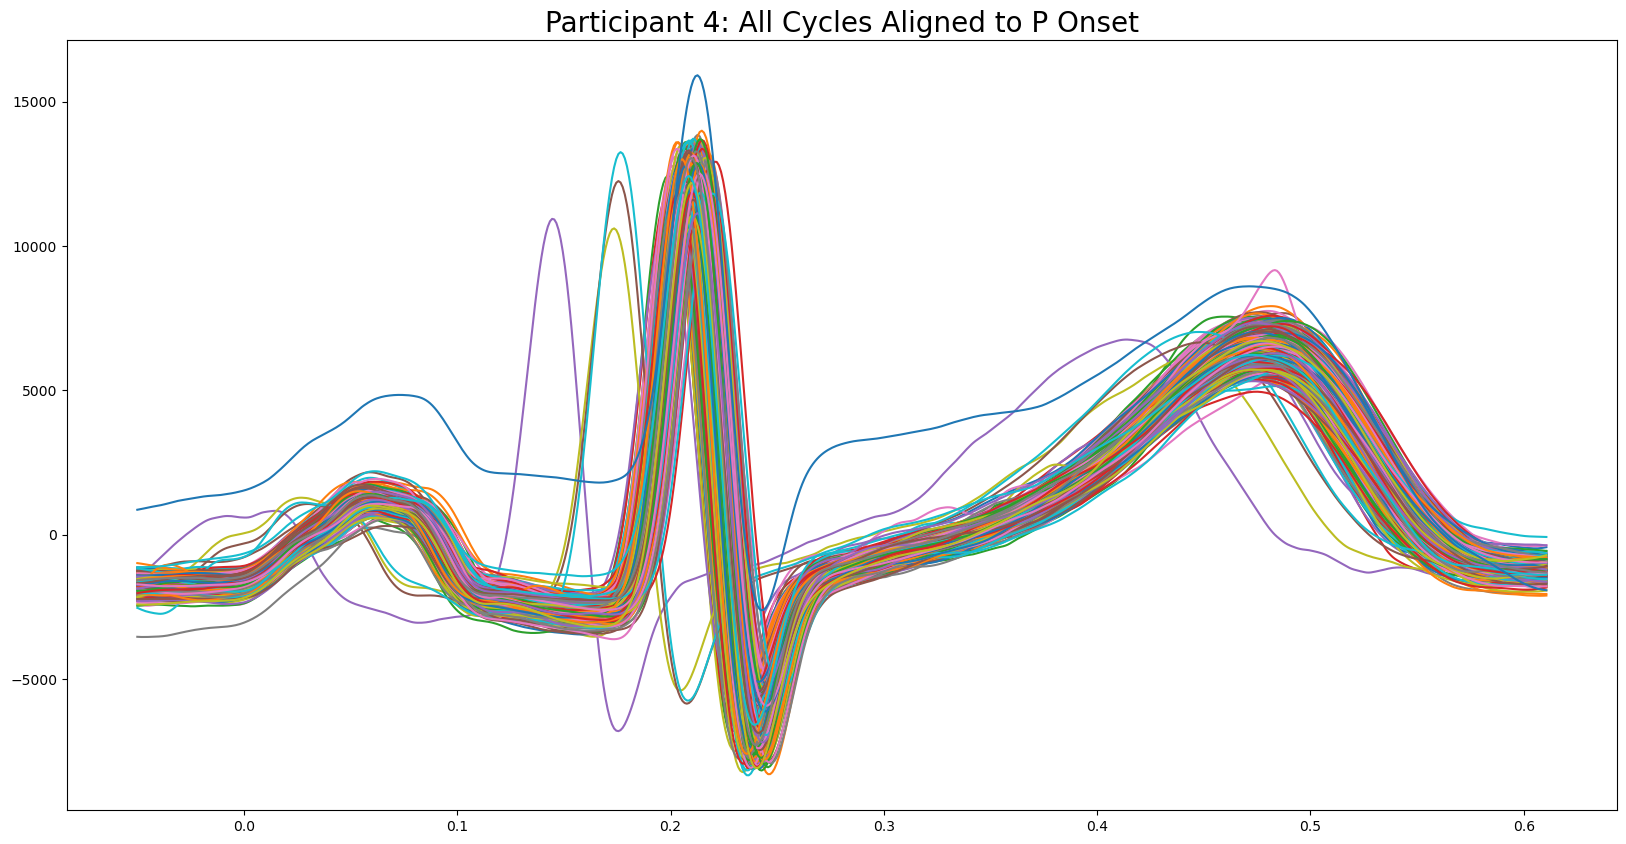

In [193]:
PLOT = True
pre_p = 50 # Buffer before P Onset

##########??????????????????
#########??????????????????
#########??????????????????
##########??????????????????
#########??????????????????
#########??????????????????
#########???????????????????
#########??????????????????
#########??????????????????
#########??????????????????
#########??????????????????
#########??????????????????
#########??????????????????
### Should we add 50 after?
post_p = 50


avg_cycle_len = cycle_mean + 50 # Buffer after end of cycle
r_latencies = np.zeros(len(no_nan_p_on))
ecg_clean_idx = np.arange(0,len(ecg_clean))
qrs_epochs_df = pd.DataFrame(columns=['signal_x', 'signal_y', 'index', 'cycle']) 
fig = plt.gcf()

for idx, p_on in enumerate(no_nan_p_on):

    window = ecg_clean[int(p_on) - int(pre_p): int(p_on) + int(avg_cycle_len)]
    
    x_vals = np.linspace(-pre_p/FS, avg_cycle_len/FS, len(window))

    temp_df = pd.DataFrame(columns=qrs_epochs_df.columns)
    temp_df['signal_x'] = x_vals
    temp_df['signal_y'] = window
    temp_df['index'] = ecg_clean_idx[int(p_on) - int(pre_p): int(p_on) + int(avg_cycle_len)]
    temp_df['cycle'] = np.repeat(idx+1, len(x_vals))
    qrs_epochs_df = pd.concat([qrs_epochs_df, temp_df])

    r_peak_ind = np.argmax(window)
    r_latencies[idx] = x_vals[r_peak_ind]
    plt.plot(x_vals, window)
    # else:
    #     continue
plt.title(f'Participant {SUB_NUM}: All Cycles Aligned to P Onset', size=20)
plt.show()
if PLOT:
    fig.savefig(f'../figures/{SUB_NUM}_allcycles_alignedtoP.png')

## Full Cycle Variability Thresholding
Take the average cycle, then correlate each individual cycle with the average. This should isolate cycles that are wildly different from the mean.

In [ ]:
# Only include y values
qrs_epochs_yvals = qrs_epochs_df[['signal_y', 'cycle']]
# Take mean of all cycles
qrs_epochs_yvals_piv = qrs_epochs_yvals.pivot(columns='cycle')
all_cycles_mean = qrs_epochs_yvals_piv.mean(axis=1)

In [ ]:
from scipy.stats import linregress
rvals = np.zeros(len(qrs_epochs_yvals_piv.columns))
for idx, col in enumerate(qrs_epochs_yvals_piv.columns):
    cycle = qrs_epochs_yvals_piv[col]
    reg_output = linregress(cycle, all_cycles_mean)
    rvals[idx] = reg_output.rvalue

In [ ]:
exclude = np.quantile(rvals, 0.1)
idx_to_exclude = []
for idx, r in enumerate(rvals):
    if r < exclude:
        idx_to_exclude.append(idx+1)

In [ ]:
PLOT = True
fig = plt.gcf()
for idx, col in enumerate(qrs_epochs_yvals_piv.columns):
    if (idx+1) not in idx_to_exclude:
        plt.plot(qrs_epochs_yvals_piv[col], alpha=0.3)
plt.plot(all_cycles_mean, linewidth=5, label='all cycles mean', color='b')
plt.legend()
plt.title(f"Participant {SUB_NUM}: Top 90% 'Cleaned' Cycles Aligned to P Onset", size=20)
plt.show()
if PLOT:
    fig.savefig(f'../figures/{SUB_NUM}_allcycles_cleaned.png')

## PARAMETERIZATION: Fit Gaussians

### Isolate one cycle for testing
** Brad noted that we are missing some features here

In [ ]:
ecg_output = pd.DataFrame({"cycle": np.arange(0, len(qrs_epochs_df['cycle'].unique())),
                           "p_center": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "p_height": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "p_width": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "q_center": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "q_height": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "q_width": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "r_center": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "r_height": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "r_width": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "s_center": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "s_height": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "s_width": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "t_center": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "t_height": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "t_width": np.zeros(len(qrs_epochs_df['cycle'].unique())),
                           "r_squared": np.zeros(len(qrs_epochs_df['cycle'].unique()))})

ecg_output

In [ ]:
PLOT = False
med_r_peak = qrs_epochs_df[qrs_epochs_df['index'].isin(list(rpeaks))]['signal_y'].median()
std_r_peak = qrs_epochs_df[qrs_epochs_df['index'].isin(list(rpeaks))]['signal_y'].std()
STD_R_HEIGHT = 10
FWHM_Q_IND = 5
FWHM_S_IND = 5

# for cycle in (ecg_output[ecg_output['r_squared']<0.9]['cycle']).values:
for cycle in np.arange(0, len((qrs_epochs_df['cycle'].unique()))): 
    if cycle in idx_to_exclude:
        print(f"Skipping cycle #{cycle} b/c excluded from prior thresholding.")
        continue
    else:
        print(f"Parameterizing cycle #{cycle}.")
        
        one_cycle = qrs_epochs_df.loc[qrs_epochs_df['cycle'] == cycle]

        if one_cycle.empty:
            print(f'cycle #{cycle} is empty')
            continue
        
        if one_cycle['signal_y'].isnull().values.any():
            print(f'cycle #{cycle} has NaNs')
            continue
        
        # X values
        xs = np.arange(one_cycle['index'].iloc[0], one_cycle['index'].iloc[-1]+1)

        sig = one_cycle['signal_y']
        sig = np.asarray(sig)

        # # Offset correction
        # cycle_min = abs(min(sig))
        # sig = sig + 2*(cycle_min)
        sig_flat = detrend(sig)
        sig = sig_flat - np.mean(sig_flat[0:25])

        ##### Defining R guesses first #####
        r_ind = np.argmax(sig)
        r_height = sig[r_ind]
        r_center = xs[r_ind]

        # Skip this cycle if the R is +/- some SD of median R peak y value
        if r_height < med_r_peak - (STD_R_HEIGHT*std_r_peak) or r_height > med_r_peak + (STD_R_HEIGHT*std_r_peak):
            print(f'cycle #{cycle} has an outlier R peak')
            continue

        # Data-driven first guess at standard deviation
        #   Find half height index on each side of the center value
        half_r_height = 0.5 * r_height
        le_ind_r = next((val for val in range(r_ind - 1, 0, -1)
                        if np.abs(sig[val]) <= np.abs(half_r_height)), None)
        ri_ind_r = next((val for val in range(r_ind + 1, len(sig), 1)
                        if np.abs(sig[val]) <= np.abs(half_r_height)), None)

        # Guess bandwidth procedure: estimate the width of the peak
        # Get an estimated width from the shortest side of the peak
        #   We grab shortest to avoid estimating very large values from overlapping peaks
        # Grab the shortest side, ignoring a side if the half max was not found
        short_side_r = min([abs(ind - r_ind) \
            for ind in [le_ind_r, ri_ind_r] if ind is not None])

        # Use the shortest side to estimate full-width, half max
        #   and use this to estimate that guess for gaussian standard deviation
        fwhm_r = short_side_r * 2

        #### Now define rest of component guesses #### 
        q_min_ind = int(r_ind-(FWHM_Q_IND*fwhm_r)) # minimum x value we think q could be (X FWHM left of r_ind)
        q_ind = np.argmin(sig[q_min_ind:r_ind]) + q_min_ind
        q_height = sig[q_ind]
        q_center = xs[q_ind]

        p_ind = np.argmax(sig[0:q_ind])
        p_height = sig[p_ind]
        p_center = xs[p_ind]

        s_max_ind = int(r_ind+(FWHM_S_IND*fwhm_r)) # maximum x value we think s could be (X FWHM right of r_ind)
        s_ind = np.argmin(sig[r_ind:s_max_ind]) + r_ind
        s_height = sig[s_ind]
        s_center = xs[s_ind]

        t_ind = np.argmax(sig[s_ind:-1]) + s_ind
        t_height = sig[t_ind]
        t_center = xs[t_ind]

        component_inds = {'p': [p_ind, p_height, p_center],
                        'q': [q_ind, q_height, q_center],
                        'r': [r_ind, r_height, r_center], 
                        's': [s_ind, s_height, s_center],
                        't': [t_ind, t_height, t_center]}

        # Initialize matrix of guess parameters for gaussian fitting
        guess = np.empty([0, 3])

        # Skip cycle if any of the expected positive components are negative
        if component_inds['p'][1] < 0:
            print(f"cycle #{cycle}'s p component is negative")
            continue
        if component_inds['r'][1] < 0:
            print(f"cycle #{cycle}'s r component is negative")
            continue
        if component_inds['t'][1] < 0:
            print(f"cycle #{cycle}'s t component is negative")
            continue

        for comp, params in component_inds.items():
            
            half_height = 0.5 * params[1]
            le_ind = next((val for val in range(params[0] - 1, 0, -1)
                if np.abs(sig[val]) <= np.abs(half_height)), None)
            ri_ind = next((val for val in range(params[0] + 1, len(sig), 1)
                if np.abs(sig[val]) <= np.abs(half_height)), None)       

            # Guess bandwidth procedure: estimate the width of the peak
            # Get an estimated width from the shortest side of the peak
            #   We grab shortest to avoid estimating very large values from overlapping peaks
            # Grab the shortest side, ignoring a side if the half max was not found
            short_side = min([abs(ind - params[0]) \
                for ind in [le_ind, ri_ind] if ind is not None])

            # Use the shortest side to estimate full-width, half max
            #   and use this to estimate that guess for gaussian standard deviation
            fwhm = short_side * 2
            guess_std = compute_gauss_std(fwhm)

            # Collect guess parameters and subtract this guess gaussian from the data
            guess = np.vstack((guess, (params[2], params[1], guess_std)))
            peak_gauss = gaussian_function(xs, params[2], params[1], guess_std)
            


        # center, height, width
        lo_bound = [[guess[0][0]- 0.5*guess[0][2], -np.inf, guess[0][2] - 2*guess[0][2]],
                [guess[1][0]- 0.5*guess[1][2], -np.inf, guess[1][2] - 2*guess[1][2]], 
                [guess[2][0]- 0.5*guess[2][2], -np.inf, guess[2][2] - 0.2*guess[2][2]],
                [guess[3][0]- 0.5*guess[3][2], -np.inf, guess[3][2] - 0.2*guess[3][2]],
                [guess[4][0]- 0.5*guess[4][2], -np.inf, guess[4][2] - 2*guess[4][2]]]

        hi_bound = [[guess[0][0]+ 0.5*guess[0][2], np.inf, guess[0][2] + 2*guess[0][2]],
                    [guess[1][0]+ 0.5*guess[1][2], np.inf, guess[1][2] + 2*guess[1][2]], 
                    [guess[2][0]+ 0.5*guess[2][2], np.inf, guess[2][2] + 0.2*guess[2][2]],
                    [guess[3][0]+ 0.5*guess[3][2], np.inf, guess[3][2] + 0.2*guess[3][2]],
                    [guess[4][0]+ 0.5*guess[4][2], np.inf, guess[4][2] + 2*guess[4][2]]]
        
        # Unpacks the embedded lists into flat tuples
        #   This is what the fit function requires as input
        gaus_param_bounds = (tuple([item for sublist in lo_bound for item in sublist]),
                            tuple([item for sublist in hi_bound for item in sublist]))
        
        # Flatten guess, for use with curve fit
        guess_flat = np.ndarray.flatten(guess)

        maxfev = 5000

        # Fit the peaks
        gaussian_params, _ = curve_fit(gaussian_function, xs, sig,
                                p0=guess_flat, maxfev=maxfev, bounds=gaus_param_bounds)
        
        fit = gaussian_function(xs, *gaussian_params)

        if PLOT:
            plt.plot(xs, sig, label='raw')
            plt.plot(xs, fit, label='fit')
            plt.show()

        r_squared = calc_r_squared(sig, fit)
        
        if r_squared < 0.9:
            plt.plot(xs, sig, label='raw')
            plt.plot(xs, fit, label='fit')
            plt.show()      

        # Add features to dataframe
        ecg_output.iloc[cycle, 1:16] = gaussian_params
        ecg_output.loc[cycle, "r_squared"] = r_squared


In [ ]:
def excluded_cyles(feature):
    if feature == 0:
        return True
    else:
        return False
    
ecg_output['excluded'] = ecg_output['p_center'].apply(excluded_cyles)
ecg_output

ecg_output.to_csv(f'../saved_files/ecg_bycycle_{SUB_NUM}.csv')

## Visualize Waveform Shape Features

In [ ]:
# SUB_NUM = {SUB_NUM}
ecg_output = pd.read_csv(f'../saved_files/ecg_bycycle_{SUB_NUM}.csv', index_col=0)
ecg_output_clean = ecg_output[ecg_output['excluded']==False]

In [ ]:
plt.rcParams["figure.figsize"] = (7, 5)

In [ ]:
print(ecg_output.columns)

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to map feature types to colors
color_map = {'width': 'blue', 'height': 'orange', 'center': 'gray'}


# Separate features based on type
width_features = [feat for feat in ecg_output_clean.columns if 'width' in feat]
height_features = [feat for feat in ecg_output_clean.columns if 'height' in feat]
center_features = [feat for feat in ecg_output_clean.columns if 'center' in feat]

# Function to plot histograms
def plot_histograms(features, title, sub_num):
    fig, axes = plt.subplots(1, len(features), figsize=(15, 4))
    fig.suptitle(title + f' - SUB_NUM: {sub_num}', y=1.02)  # Include SUB_NUM in the main title
    
    # Adjust layout to prevent overlapping y-axis labels and increase space
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for i, feat in enumerate(features):
        color = color_map['width'] if 'width' in feat else color_map['height']
        axes[i].hist(ecg_output_clean[feat], color=color, alpha=0.7)
        axes[i].set_title(feat)

# Plot width features in the same line
plot_histograms(width_features, 'Width Features', SUB_NUM)

# Plot height features in the same line
plot_histograms(height_features, 'Height Features', SUB_NUM)

plt.show()



## Autocorrelations 

Plot the autocorrelations of each feature

In [ ]:
# Autocorrelation
from statsmodels.tsa.stattools import acf

In [ ]:
NLAGS = 50
fig = plt.gcf()
for col in ecg_output_clean.columns:
    if 'height' in col:
        plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
                 label=col)
plt.legend()
plt.title(f'Participant {SUB_NUM}: Component Height ACF')
plt.show()
fig.savefig(f'../figures/{SUB_NUM}_acf_height.png', transparent=False)

NLAGS = 50
fig = plt.gcf()
for col in ecg_output_clean.columns:
    if 'width' in col:
        plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
                 label=col)
plt.legend()
plt.title(f'Participant {SUB_NUM}: Component Width ACF')
plt.show()
fig.savefig(f'../figures/{SUB_NUM}_acf_width.png', transparent=False)

In [ ]:
NLAGS = 50
fig = plt.gcf()
for col in ecg_output_clean.columns:
    if 'width' in col:
        plt.plot(np.arange(0,(NLAGS+1)), acf(ecg_output[col], nlags=NLAGS), 
                 label=col)
plt.legend()
plt.title(f'Participant {SUB_NUM}: Component Width ACF')
plt.show()
fig.savefig(f'../figures/{SUB_NUM}_acf_width.png', transparent=False)